In [113]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [114]:
# read the words
words = open('names.txt', 'r').read().splitlines()
len(words), words[:5]

(32033, ['emma', 'olivia', 'ava', 'isabella', 'sophia'])

In [115]:
# build the vocabulary
chars = sorted(list(set(''.join(words))))
s_to_i = {'.' : 0} | {s: i + 1 for i, s in enumerate(chars)}
i_to_s = {i: s for s, i in s_to_i.items()}
vocab_size = len(i_to_s)
print(i_to_s)
print(vocab_size)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27


In [116]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [117]:
# build the dataset

block_size = 8 # context length (how many chars to predict next)

def build_dataset(words):
	X, Y = [], []

	for w in words:
		context = [0] * block_size
		for ch in w + '.':
			idx = s_to_i[ch]
			X.append(context)
			Y.append(idx)
			context = context[1:] + [idx]
	
	X = torch.tensor(X)
	Y = torch.tensor(Y)
	print(X.shape, Y.shape)
	return X, Y

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
X_train,	Y_train	= build_dataset(words[:n1])		# 80%
X_val,		Y_val	= build_dataset(words[n1:n2])	# 10%
X_test,		Y_test	= build_dataset(words[n2:])		# 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [118]:
for x, y in zip(X_train[:20], Y_train[:20]):
	print(''.join([i_to_s[i.item()] for i in x]), '--->', i_to_s[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [119]:
class Linear:
	def __init__(self, fan_in, fan_out, bias=True):
		self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
		self.bias = torch.zeros(fan_out) if bias else None
	
	def __call__(self, x):
		self.out = x @ self.weight
		if self.bias is not None:
			self.out += self.bias
		return self.out
	
	def parameters(self):
		return [self.weight] + ([] if self.bias is None else [self.bias])

In [120]:
class BatchNorm1d:
	def __init__(self, dim, eps=1e-5, momentum=0.1):
		self.eps = eps
		self.momentum = momentum
		self.training = True
		# parameters trained with backprop
		self.gamma = torch.ones(dim)
		self.beta = torch.zeros(dim)
		# running statistics
		self.running_mean = torch.zeros(dim)
		self.running_var = torch.ones(dim)
	
	def __call__(self, x):
		# calculate the forward pass
		if self.training:
			if x.ndim == 2:
				dim = 0
			elif x.ndim == 3:
				dim = (0, 1)
			mean = x.mean(dim, keepdim=True) # batch mean
			var = x.var(dim, keepdim=True) # batch variance
		else:
			mean = self.running_mean
			var = self.running_var
		x_hat = (x - mean) / torch.sqrt(var + self.eps)
		self.out = self.gamma * x_hat + self.beta
		# update running statistics
		if self.training:
			with torch.no_grad():
				self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
				self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var
		return self.out
	
	def parameters(self):
		return [self.gamma, self.beta]

In [121]:
class Tanh:
	def __call__(self, x):
		self.out = torch.tanh(x)
		return self.out
	def parameters(self):
		return []

In [122]:
class Embedding:
	def __init__(self, num_embeddings, embedding_dim):
		self.weight = torch.randn((num_embeddings, embedding_dim))

	def __call__(self, x):
		self.out = self.weight[x]
		return self.out

	def parameters(self):
		return [self.weight]

In [123]:
class FlattenConsecutive:
	def __init__(self, n):
		self.n = n

	def __call__(self, x):
		self.out = x.view(x.shape[0], x.shape[1]//self.n, -1)
		if self.out.shape[1] == 1:
			self.out = self.out.squeeze(1)
		return self.out

	def parameters(self):
		return []

In [134]:
class Sequential:
	def __init__(self, layers):
		self.layers = layers
	
	def __call__(self, x):
		for layer in self.layers:
			x = layer(x)
		self.out = x
		return self.out
	
	def parameters(self):
		return [p for layer in self.layers for p in layer.parameters()]

In [135]:
torch.manual_seed(42);

In [138]:
n_embd = 10 # embedding size
n_hidden = 68 # hidden layer size

model = Sequential([
	Embedding(vocab_size, n_embd),
	FlattenConsecutive(2), Linear(n_embd   * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
	Linear(n_hidden, vocab_size),
])

with torch.no_grad():
	model.layers[-1].weight *= 0.1 # make last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
	p.requires_grad = True

22397


In [140]:
from collections import defaultdict

# Find the length of the longest class name
max_name_length = max(len(layer.__class__.__name__) for layer in model.layers)
batch_size = 32

# Initialize a defaultdict to keep track of layer type counts
layer_counts = defaultdict(int)

# Now print each layer with proper padding and numbering
if not hasattr(model.layers[0], 'out'):
    model(X_train[:batch_size])  # run the model to calculate the output shape
    print("(Ran for a batch of 32 to determine output shapes)\n")
print("Layer (Type) Name".rjust(max_name_length + 4), "| Output Shape")
for layer in model.layers:
    class_name = layer.__class__.__name__
    layer_counts[class_name] += 1
    padded_name = f"{class_name} {layer_counts[class_name]}".rjust(max_name_length + 4)  # +4 for number and spaces
    print(f"{padded_name} | {tuple(layer.out.shape)}")

     Layer (Type) Name | Output Shape
           Embedding 1 | (32, 8, 10)
  FlattenConsecutive 1 | (32, 4, 20)
              Linear 1 | (32, 4, 68)
         BatchNorm1d 1 | (32, 4, 68)
                Tanh 1 | (32, 4, 68)
  FlattenConsecutive 2 | (32, 2, 136)
              Linear 2 | (32, 2, 68)
         BatchNorm1d 2 | (32, 2, 68)
                Tanh 2 | (32, 2, 68)
  FlattenConsecutive 3 | (32, 136)
              Linear 3 | (32, 68)
         BatchNorm1d 3 | (32, 68)
                Tanh 3 | (32, 68)
              Linear 4 | (32, 27)


In [139]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

	# minibatch
	minibatch = torch.randint(0, X_train.shape[0], (batch_size,))
	Xb, Yb = X_train[minibatch], Y_train[minibatch]

	# forward pass
	logits = model(Xb)
	loss = F.cross_entropy(logits, Yb) # loss function

	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	# update: simple SGD
	lr = 0.1 if i < 100000 else 0.01
	for p in parameters:
		p.data += -lr * p.grad
	
	# track stats
	if i % 10000 == 0:
		print(f'{i:7d}/ {max_steps:7d}: {loss.item():.4f}')
	lossi.append(loss.log10().item())

	break

      0/  200000: 3.2984


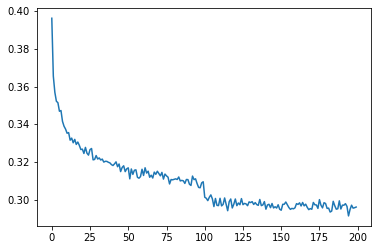

In [56]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [57]:
for layer in model.layers:
	layer.training = False

In [58]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
	x, y = {
		'train': (X_train, Y_train),
		'val': (X_val, Y_val),
		'test': (X_test, Y_test)
	}[split]
	logits = model(x)
	loss = F.cross_entropy(logits, y)
	print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9534237384796143
val 2.030740737915039


In [59]:
# sample from model

for _ in range(20):
	out = []
	context = [0] * block_size
	while True:
		logits = model(torch.tensor([context]))
		probs = F.softmax(logits, dim=1)
		ix = torch.multinomial(probs, num_samples=1).item()
		context = context[1:] + [ix]
		out.append(ix)
		if ix == 0:
			break
	
	print(''.join(i_to_s[i] for i in out[:-1]))

lansley
valiana
nelia
kailon
benoce
callie
telan
rivan
jaleid
zeyelie
isabi
synnequ
zhrylak
erishai
ilynn
andru
aaitley
quia
lawheoni
seleigh
